# Lecture 9 - Natural Language Processing

## Load Data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                    attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                    attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                    class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                    class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head()

news_headline  \
0  Facebook in talks to acquire 10% stake in Jio ...   
1  Amazon workers in 6 US warehouses test positiv...   
2  We can't return to normal too soon and ignore ...   
3  Cyber Crime Cell warns against potentially dan...   
4  Govt staff donates ₹48 cr, Microsoft CEO Satya...   

                                        news_article news_category  
0  Facebook is in talks to acquire a 10% stake in...    technology  
1  Amazon workers across six warehouses in the US...    technology  
2  World's second-richest person Bill Gates in a ...    technology  
3  The Cyber Crime Cell, Delhi on Wednesday share...    technology  
4  Several government officials donated their one...    technology

In [4]:
news_df.news_category.value_counts()

sports        25
technology    25
world         25
Name: news_category, dtype: int64

## Text Preprocessing

### Noise Removal

In [5]:
noise_list = ["is", "a", "this", "..."]

def _remove_noise(input_text):
    words = input_text.split()
    noise_free_words = [word for word in words if word not in noise_list]
    noise_free_text = " ".join(noise_free_words)
    return noise_free_text

_remove_noise("this is a sample text")

'sample text'

In [6]:
# Lower Case
news_df['news_article'] = news_df['news_article']\
            .apply(lambda x: " ".join(x.lower() for x in x.split()))
news_df['news_article'].head()

0    facebook is in talks to acquire a 10% stake in...
1    amazon workers across six warehouses in the us...
2    world's second-richest person bill gates in a ...
3    the cyber crime cell, delhi on wednesday share...
4    several government officials donated their one...
Name: news_article, dtype: object

In [7]:
# Removing Punctuation
news_df['news_article'] = news_df['news_article']\
            .str.replace('[^\w\s]','')
news_df['news_article'].head()

0    facebook is in talks to acquire a 10 stake in ...
1    amazon workers across six warehouses in the us...
2    worlds secondrichest person bill gates in a vi...
3    the cyber crime cell delhi on wednesday shared...
4    several government officials donated their one...
Name: news_article, dtype: object

In [8]:
# Removing Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
news_df['news_article'] = news_df['news_article']\
            .apply(lambda x: " ".join(x for x in x.split() if x not in stop))
news_df['news_article'].head()

0    facebook talks acquire 10 stake reliance jio t...
1    amazon workers across six warehouses us tested...
2    worlds secondrichest person bill gates virtual...
3    cyber crime cell delhi wednesday shared list c...
4    several government officials donated oneday sa...
Name: news_article, dtype: object

In [9]:
# Word Tokenization
from nltk.tokenize import word_tokenize

print(news_df['news_article'].iloc[0])
tokens = word_tokenize(news_df['news_article'].iloc[0])
print(tokens)

facebook talks acquire 10 stake reliance jio talks halted due coronavirus outbreak financial times reported tuesday adding deal size multibillion dollars analysts bernstein value jio 60 billion indias richest person mukesh ambani poured 25 billion reliance jio years
['facebook', 'talks', 'acquire', '10', 'stake', 'reliance', 'jio', 'talks', 'halted', 'due', 'coronavirus', 'outbreak', 'financial', 'times', 'reported', 'tuesday', 'adding', 'deal', 'size', 'multibillion', 'dollars', 'analysts', 'bernstein', 'value', 'jio', '60', 'billion', 'indias', 'richest', 'person', 'mukesh', 'ambani', 'poured', '25', 'billion', 'reliance', 'jio', 'years']


In [10]:
# Frequency Distribution
from nltk.probability import FreqDist

fdist = FreqDist(tokens)
fdist.most_common(2)

[('jio', 3), ('talks', 2)]

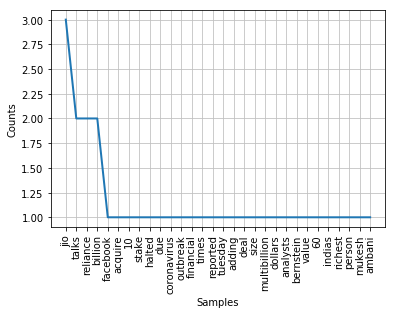

In [11]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30, cumulative=False)
plt.show()

### Lexicon Normalization

In [12]:
# Stemming
from nltk.stem import PorterStemmer

st = PorterStemmer()
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([st.stem(word) for word in x.split()]))

0    facebook talk acquir 10 stake relianc jio talk...
1    amazon worker across six warehous us test posi...
2    world secondrichest person bill gate virtual t...
3    cyber crime cell delhi wednesday share list co...
4    sever govern offici donat oneday salari amount...
Name: news_article, dtype: object

In [13]:
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([lem.lemmatize(word, "v") \
                                for word in x.split()]))

0    facebook talk acquire 10 stake reliance jio ta...
1    amazon workers across six warehouse us test po...
2    worlds secondrichest person bill gate virtual ...
3    cyber crime cell delhi wednesday share list co...
4    several government officials donate oneday sal...
Name: news_article, dtype: object

In [14]:
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([lem.lemmatize(word, "n") \
                                for word in x.split()]))

0    facebook talk acquire 10 stake reliance jio ta...
1    amazon worker across six warehouse u tested po...
2    world secondrichest person bill gate virtual t...
3    cyber crime cell delhi wednesday shared list c...
4    several government official donated oneday sal...
Name: news_article, dtype: object

In [19]:
# Object Standardization
lookup_dict = {'rt':'Retweet', 'dm':'direct message', \
               'awsm':'awesome', 'luv':'love'}

def _lookup_words(input_text):
    words = input_text.split()
    new_words = []
    for word in words:
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]

        new_words.append(word)
        new_text = " ".join(new_words)

    return new_text

_lookup_words("RT this is a retweeted tweet by Shivam Bansal")

'Retweet this is a retweeted tweet by Shivam Bansal'

## Feature Engineering

In [20]:
# Part of Speech (POS) Tagging
from nltk import word_tokenize, pos_tag

text = "I am learning Text Analytics at IVE(TY)."
tokens = word_tokenize(text)
print(pos_tag(tokens))

[('I', 'PRP'), ('am', 'VBP'), ('learning', 'VBG'), ('Text', 'NNP'), ('Analytics', 'NNP'), ('at', 'IN'), ('IVE', 'NNP'), ('(', '('), ('TY', 'NNP'), (')', ')'), ('.', '.')]


In [22]:
# N-Grams as Features
from textblob import TextBlob

TextBlob(news_df['news_article'][1]).ngrams(3)

[WordList(['amazon', 'workers', 'across']),
 WordList(['workers', 'across', 'six']),
 WordList(['across', 'six', 'warehouses']),
 WordList(['six', 'warehouses', 'us']),
 WordList(['warehouses', 'us', 'tested']),
 WordList(['us', 'tested', 'positive']),
 WordList(['tested', 'positive', 'coronavirus']),
 WordList(['positive', 'coronavirus', 'washington']),
 WordList(['coronavirus', 'washington', 'post']),
 WordList(['washington', 'post', 'reported']),
 WordList(['post', 'reported', 'amazon']),
 WordList(['reported', 'amazon', 'shut']),
 WordList(['amazon', 'shut', 'warehouses']),
 WordList(['shut', 'warehouses', 'asked']),
 WordList(['warehouses', 'asked', 'employees']),
 WordList(['asked', 'employees', 'came']),
 WordList(['employees', 'came', 'contact']),
 WordList(['came', 'contact', 'infected']),
 WordList(['contact', 'infected', 'staff']),
 WordList(['infected', 'staff', 'quarantined']),
 WordList(['staff', 'quarantined', 'earlier']),
 WordList(['quarantined', 'earlier', 'reported']

In [23]:
## Statistical Features
# Term frequency (TF)
tf1 = (news_df['news_article'][1:2]).apply(lambda x: \
                    pd.value_counts(x.split(" ")))\
                    .sum(axis = 0).reset_index()
tf1.columns = ['words', 'tf']
tf1.head()

words  tf
0      amazon   3
1    reported   2
2  warehouses   2
3      tested   2
4     workers   2

In [24]:
# Inverse Document Frequency (IDF)
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(news_df.shape[0]/\
                        (len(news_df[news_df['news_article']\
                        .str.contains(word)])))

tf1.head()

words  tf       idf
0      amazon   3  3.624341
1    reported   2  1.373049
2  warehouses   2  4.317488
3      tested   2  2.525729
4     workers   2  2.708050

In [25]:
# TF-IDF
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.head()

words  tf       idf      tfidf
0      amazon   3  3.624341  10.873023
1    reported   2  1.373049   2.746098
2  warehouses   2  4.317488   8.634976
3      tested   2  2.525729   5.051457
4     workers   2  2.708050   5.416100

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
            stop_words= 'english', ngram_range=(1,1))

news_vect = tfidf.fit_transform(news_df['news_article'][1:2])
print(news_vect)

  (0, 0)	0.457495710997814
  (0, 19)	0.30499714066520933
  (0, 17)	0.30499714066520933
  (0, 16)	0.30499714066520933
  (0, 9)	0.30499714066520933
  (0, 4)	0.15249857033260467
  (0, 18)	0.15249857033260467
  (0, 10)	0.15249857033260467
  (0, 12)	0.30499714066520933
  (0, 13)	0.15249857033260467
  (0, 1)	0.15249857033260467
  (0, 6)	0.15249857033260467
  (0, 2)	0.15249857033260467
  (0, 3)	0.15249857033260467
  (0, 7)	0.15249857033260467
  (0, 15)	0.15249857033260467
  (0, 11)	0.15249857033260467
  (0, 5)	0.15249857033260467
  (0, 14)	0.15249857033260467
  (0, 8)	0.15249857033260467


## Important Text Analytics Tasks

### 1. Sentiment Analysis

In [30]:
# Sentiment Analysis Using TextBlob
from textblob import TextBlob

news_df['news_article'][:5].apply(lambda x: TextBlob(x).sentiment)

0                            (-0.0625, 0.1875)
1    (0.15151515151515152, 0.5303030303030303)
2                               (0.0375, 0.35)
3                 (-0.09999999999999999, 0.45)
4                                  (0.0, 0.15)
Name: news_article, dtype: object

In [36]:
# Sentiment Analysis Using NLTK
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
 
def word_feats(word):
    return dict([(char, True) for char in word])
 
positive_vocab = [ 'awesome', 'outstanding', 'fantastic', 'terrific', 'good', 'nice', 'great', ':)' ]
negative_vocab = [ 'bad', 'terrible','useless', 'hate', ':(' ]
neutral_vocab = [ 'movie','the','sound','was','is','actors','did','know','words','not' ]
 
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]
 
train_set = negative_features + positive_features + neutral_features
 
classifier = NaiveBayesClassifier.train(train_set) 
 
# Predict
neg = 0
pos = 0
sentence = "Awesome movie, I liked it"
sentence = sentence.lower()
words = sentence.split(' ')

for word in words:
    classResult = classifier.classify( word_feats(word))
    if classResult == 'neg':
        neg = neg + 1
    if classResult == 'pos':
        pos = pos + 1
 
print('Positive: ' + str(float(pos)/len(words)))
print('Negative: ' + str(float(neg)/len(words)))

Positive: 0.6
Negative: 0.2


### 2. Text Classification

In [31]:
from textblob.classifiers import NaiveBayesClassifier as NBC
from textblob import TextBlob

training_corpus = [
    ('I am exhausted of this work.', 'Class_B'),
    ("I can't cooperate with this", 'Class_B'),
    ('He is my badest enemy!', 'Class_B'),
    ('My management is poor.', 'Class_B'),
    ('I love this burger.', 'Class_A'),
    ('This is an brilliant place!', 'Class_A'),
    ('I feel very good about these dates.', 'Class_A'),
    ('This is my best work.', 'Class_A'),
    ("What an awesome view", 'Class_A'),
    ('I do not like this dish', 'Class_B')]

test_corpus = [
    ("I am not feeling well today.", 'Class_B'),
    ("I feel brilliant!", 'Class_A'),
    ('Gary is a friend of mine.', 'Class_A'),
    ("I can't believe I'm doing this.", 'Class_B'),
    ('The date was good.', 'Class_A'), ('I do not enjoy my job', 'Class_B')]

model = NBC(training_corpus)
print(model.classify("Their codes are amazing."))

Class_A


In [32]:
print(model.classify("I don't like their computer."))

Class_B


In [33]:
print(model.accuracy(test_corpus))

0.8333333333333334


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import svm

# Preparing data for SVM model (using the same training_corpus, test_corpus
#   from naive bayes example)
train_data = []
train_labels = []
for row in training_corpus:
    train_data.append(row[0])
    train_labels.append(row[1])

test_data = []
test_labels = []
for row in test_corpus:
    test_data.append(row[0])
    test_labels.append(row[1])

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=4, max_df=0.9)

# Train the feature vectors
train_vectors = vectorizer.fit_transform(train_data)

# Apply model on test data
test_vectors = vectorizer.transform(test_data)

# Perform classification with SVM, kernel=linear
model = svm.SVC(kernel='linear')
model.fit(train_vectors, train_labels)
prediction = model.predict(test_vectors)
print(prediction)
# print(classification_report(test_labels, prediction))

['Class_A' 'Class_A' 'Class_B' 'Class_B' 'Class_A' 'Class_A']


### 3. Chatbot